In [1]:
import scipy
import keras
import tensorflow as tf
from keras import backend as K
from keras import initializers
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape, Concatenate, Flatten
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(903347941)

In [2]:
# MAP@K
# With reference to: https://github.com/benhamner/Metrics/pull/54/commits/0bfbf3f6b980ee28b33dd08d4d70114a3261c2ef?diff=split&w=0
def ap_k(true, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]

    sum_precision = 0.0
    num_hits = 0.0

    for i, prediction in enumerate(predicted):
        if prediction in true[:k] and prediction not in predicted[:i]:
            num_hits += 1.0
            precision_at_i = num_hits / (i + 1.0)
            sum_precision += precision_at_i

    if num_hits == 0.0:
        return 0.0

    return sum_precision / num_hits

def map_k(true_pred, users, k):
    ap_ks = []
    for i in range(users):
        user = true_pred[true_pred[:,0]==i]
        true = user[user[:,-2]==1][:, 1] # Get the recommended
        preds = user[user[:,-1].argsort()[::-1]][:,1] # Highest Scores first
        ap_k_val = ap_k(true, preds, k)
        ap_ks.append(ap_k_val)
    return np.mean(ap_ks)

# Hit Rate
def hit_ratio_k(true_pred, users, k):
    hits = 0
    for i in range(users):
        user = true_pred[true_pred[:,0]==i]
        true = user[user[:,-2]==1][:, 1][:k] # Get the recommended
        preds = user[user[:,-1].argsort()[::-1]][:,1][:k] # Highest Scores first
        hits += len(set(preds).intersection(set(true))) > 0
    return hits / users

### References:
Code references for benchmarks
1. <b> NCF Code Base Reference </b><br>
https://github.com/hexiangnan/neural_collaborative_filtering
2. <b> Hit Rate @ K </b><br>
https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54#:~:text=In%20recommender%20settings%2C%20the%20hit,included%20in%20the%20recommendation%20list.


### Metrics

### Read in Data

In [3]:
# Data
int_mat = scipy.sparse.load_npz('../data/sparse_interaction_matrix.npz')
twsir_mat = scipy.sparse.load_npz('../data/sparse_twsir_matrix.npz')

int_np = int_mat.toarray()
twsir_np = twsir_mat.toarray()

# TWSIR
# int_index_grt_20 = np.where((np.count_nonzero(int_np[:, random_restaurants], axis=1) >= 20))[0]
int_index_grt_20 = np.where((np.count_nonzero(int_np, axis=1) >= 20))[0]
# int_np_grt_20 = int_np[:, random_restaurants][int_index_grt_20, :]
int_np_grt_20 = int_np[int_index_grt_20, :]

int_dataless_cols = np.where(np.sum(int_np_grt_20, axis=0)<2)[0]
int_filtered_cols = [i for i in range(int_np_grt_20.shape[1]) if i not in int_dataless_cols]
int_np_grt_20 = int_np_grt_20[:,int_filtered_cols]
# int_random_restaurants_w_data = sorted(random_restaurants[[i for i in range(random_restaurants.shape[0]) if i not in int_dataless_cols]])

In [4]:
# TWSIR
# twsir_index_grt_20 = np.where((np.count_nonzero(twsir_np[:, random_restaurants], axis=1) >= 20))[0]
twsir_index_grt_20 = np.where((np.count_nonzero(twsir_np, axis=1) >= 20))[0]
# twsir_np_grt_20 = twsir_np[:, random_restaurants][twsir_index_grt_20, :]
twsir_np_grt_20 = twsir_np[twsir_index_grt_20, :]

twsir_dataless_cols = np.where(np.sum(twsir_np_grt_20, axis=0)<2)[0]
twsir_filtered_cols = [i for i in range(twsir_np_grt_20.shape[1]) if i not in twsir_dataless_cols]
twsir_np_grt_20 = twsir_np_grt_20[:,twsir_filtered_cols]
# twsir_random_restaurants_w_data = sorted(random_restaurants[[i for i in range(random_restaurants.shape[0]) if i not in twsir_dataless_cols]])

In [5]:
# For BUI
X_train_int, Y_train_int = np.array([]).reshape(0,2), np.array([])
X_test_int, Y_test_int = np.array([]).reshape(0,2), np.array([])

for i in range(int_np_grt_20.shape[0]):
    xtrain, xtest, ytrain, ytest = train_test_split(np.arange(int_np_grt_20.shape[1]), int_np_grt_20[i], test_size=0.2, 
                                                  random_state=903347941, stratify=int_np_grt_20[i])

    # For Test, we reduce the time needed to evaluate
    # Positive Samples
    pos = np.where(ytest==1)[0]

    # Negative Samples
    neg = np.random.choice(np.where(ytest==0)[0], 100, replace=True)

    # Test Samples
    test_idx = np.concatenate([pos, neg])

    xtest = xtest[test_idx]
    xtrain_np = np.array([*zip([i]*len(xtrain), xtrain)])
    xtest_np = np.array([*zip([i]*len(xtest), xtest)])
    X_train_int = np.vstack([X_train_int, xtrain_np])
    X_test_int = np.vstack((X_test_int, xtest_np))

    Y_train_int = np.append(Y_train_int, int_np_grt_20[i, xtrain])
    Y_test_int = np.append(Y_test_int, int_np_grt_20[i, xtest])


In [6]:
# For TWSIR
X_train_twsir, Y_train_twsir = np.array([]).reshape(0,2), np.array([])
X_test_twsir, Y_test_twsir = np.array([]).reshape(0,2), np.array([])

for i in range(twsir_np_grt_20.shape[0]):
    xtrain, xtest, ytrain, ytest = train_test_split(np.arange(twsir_np_grt_20.shape[1]), twsir_np_grt_20[i], test_size=0.2, 
                                                  random_state=903347941, stratify=twsir_np_grt_20[i])

    # For Test, we reduce the time needed to evaluate
    # Positive Samples
    pos = np.where(ytest==1)[0]

    # Negative Samples
    neg = np.random.choice(np.where(ytest==0)[0], 100, replace=True)

    # Test Samples
    test_idx = np.concatenate([pos, neg])

    xtest = xtest[test_idx]
    xtrain_np = np.array([*zip([i]*len(xtrain), xtrain)])
    xtest_np = np.array([*zip([i]*len(xtest), xtest)])
    X_train_twsir = np.vstack([X_train_twsir, xtrain_np])
    X_test_twsir = np.vstack((X_test_twsir, xtest_np))

    Y_train_twsir = np.append(Y_train_twsir, twsir_np_grt_20[i, xtrain])
    Y_test_twsir = np.append(Y_test_twsir, twsir_np_grt_20[i, xtest])


In [7]:
train_indices = np.arange(X_train_int.shape[0])
np.random.shuffle(train_indices)
X_train_int, Y_train_int = X_train_int[train_indices], Y_train_int[train_indices]

test_indices = np.arange(X_test_int.shape[0])
np.random.shuffle(test_indices)
X_test, Y_test_int = X_test_int[test_indices], Y_test_int[test_indices]

X_train_int, X_test_int = X_train_int.astype('int'), X_test_int.astype('int')

In [8]:
train_indices = np.arange(X_train_twsir.shape[0])
np.random.shuffle(train_indices)
X_train_twsir, Y_train_twsir = X_train_twsir[train_indices], Y_train_twsir[train_indices]

test_indices = np.arange(X_test_twsir.shape[0])
np.random.shuffle(test_indices)
X_test_twsir, Y_test_twsir = X_test_twsir[test_indices], Y_test_twsir[test_indices]

X_train_twsir, X_test_twsir = X_train_twsir.astype('int'), X_test_twsir.astype('int')

In [9]:
attr = pd.read_csv('../data/attr_aspect.csv')
# TWSIR
train_attr_features_twsir = pd.DataFrame(X_train_twsir, columns=['account_id','restaurant_uuid']).merge(attr, how='left', on=['restaurant_uuid']).fillna(0)
attr_twsir_train = train_attr_features_twsir.values[:, 2:].astype('int')
test_attr_features_twsir = pd.DataFrame(X_test_twsir, columns=['account_id','restaurant_uuid']).merge(attr, how='left', on=['restaurant_uuid']).fillna(0)
attr_twsir_test = test_attr_features_twsir.values[:, 2:].astype('int')

# BUI
train_attr_features_int = pd.DataFrame(X_train_int, columns=['account_id','restaurant_uuid']).merge(attr, how='left', on=['restaurant_uuid']).fillna(0)
attr_int_train = train_attr_features_int.values[:, 2:].astype('int')
test_attr_features_int = pd.DataFrame(X_test_int, columns=['account_id','restaurant_uuid']).merge(attr, how='left', on=['restaurant_uuid']).fillna(0)
attr_int_test = test_attr_features_int.values[:, 2:].astype('int')

In [10]:
# Read in Word Embedding File
word_embed = pd.read_csv('../data/word_embed.csv')

In [11]:
# TWSIR
train_text_features_twsir = pd.DataFrame(X_train_twsir, columns=['account_uuid', 'restaurant_uuid']).merge(word_embed, how='left', on=['account_uuid', 'restaurant_uuid']).fillna(0)
text_twsir_train = train_text_features_twsir.values[:,2:]
test_text_features_twsir = pd.DataFrame(X_test_twsir, columns=['account_uuid', 'restaurant_uuid']).merge(word_embed, how='left', on=['account_uuid', 'restaurant_uuid']).fillna(0)
text_twsir_test = test_text_features_twsir.values[:,2:]

# BUI
train_text_features_int = pd.DataFrame(X_train_int, columns=['account_uuid', 'restaurant_uuid']).merge(word_embed, how='left', on=['account_uuid', 'restaurant_uuid']).fillna(0)
text_int_train = train_text_features_int.values[:,2:]
test_text_features_int = pd.DataFrame(X_test_int, columns=['account_uuid', 'restaurant_uuid']).merge(word_embed, how='left', on=['account_uuid', 'restaurant_uuid']).fillna(0)
text_int_test = test_text_features_int.values[:,2:]

In [12]:
print("Sparsity of TWSIR Matrix:", (twsir_np_grt_20==0).sum()/twsir_np_grt_20.size)
print("Sparsity of BUI Matrix:",(int_np_grt_20==0).sum()/int_np_grt_20.size)
print("TWSIR (Users, Restaurants)", twsir_np_grt_20.shape)
print("BUI (Users, Restaurants)", int_np_grt_20.shape)
print("TWSIR Interactions", (twsir_np_grt_20!=0).sum())
print("BUI Interactions", (int_np_grt_20!=0).sum())

Sparsity of TWSIR Matrix: 0.989915649302775
Sparsity of BUI Matrix: 0.991225930169634
TWSIR (Users, Restaurants) (1058, 8151)
BUI (Users, Restaurants) (1783, 10474)
TWSIR Interactions 86965
BUI Interactions 163857


## Experiment 1

### Neural Matrix Factorization or NeuMF (Benchmark Model)

In [13]:
def neumf(users, restaurants, latent_dim, layers=[32,16], regs=[0,0]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    rest_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    # GMF
    mf_user_embed = Embedding(input_dim = users, output_dim = latent_dim, name = 'mf_user_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)
    mf_rest_embed = Embedding(input_dim = restaurants, output_dim = latent_dim, name = 'mf_rest_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)

    mf_user_latent = Flatten()(mf_user_embed(user_input))
    mf_rest_latent = Flatten()(mf_rest_embed(rest_input))

    mf_predict_input = mf_user_latent * mf_rest_latent

    # NCF
    ncf_user_embed = Embedding(input_dim = users, output_dim = layers[0]//2, name = 'ncf_user_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)
    ncf_rest_embed = Embedding(input_dim = restaurants, output_dim = layers[0]//2, name = 'ncf_rest_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)

    ncf_user_latent = Flatten()(ncf_user_embed(user_input))
    ncf_rest_latent = Flatten()(ncf_rest_embed(rest_input))

    ncf_prediction_input = Concatenate()([ncf_user_latent, ncf_rest_latent])

    for i in range(len(layers)):
        ncf_dense = Dense(layers[i], kernel_regularizer=l2(regs[i]), activation='relu', name=f'layer{i}')
        ncf_predict_input = ncf_dense(ncf_prediction_input)

    neumf_predict_input = Concatenate()([mf_predict_input, ncf_predict_input])

    neumf_predict_output = Dense(1, activation='sigmoid', name='output')(neumf_predict_input)

    neumf_model = Model(inputs=[user_input, rest_input], outputs=neumf_predict_output)
    return neumf_model

### Benchmark with BUI

In [14]:
EPOCHS = 10
PREDICTIVE_LAYERS = [4, 8, 16, 32]
REGS = [0,0,0]
LATENT_DIM = 8
USER_NUM, REST_NUM = int_np_grt_20.shape
LR = 1e-3
BATCH_SIZE = 1024
bm_bui_mapks = []
bm_bui_hrs = []

for layer in PREDICTIVE_LAYERS:
    tf.random.set_seed(903347941)
    MLP_DENSE = [layer*4,layer*2,layer]
    nmf = neumf(USER_NUM, REST_NUM, LATENT_DIM, layers=MLP_DENSE, regs=REGS)
    nmf.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy')

    nmf.fit([X_train_int[:, :1], X_train_int[:, 1:]], Y_train_int, batch_size=BATCH_SIZE, epochs=EPOCHS)
    predictions = nmf.predict([X_test_int[:, :1], X_test_int[:, 1:]])
    true_pred = np.hstack((X_test_int, Y_test_int.reshape(-1,1), predictions))
    mapk = map_k(true_pred, USER_NUM, 10)
    hr = hit_ratio_k(true_pred, USER_NUM, 10)
    print(mapk, hr)
    bm_bui_mapks.append(mapk)
    bm_bui_hrs.append(hr)

Epoch 1/10
14590/14590 [==============================] - 14s 826us/step - loss: 0.0459
Epoch 2/10
14590/14590 [==============================] - 12s 812us/step - loss: 0.0372
Epoch 3/10
14590/14590 [==============================] - 12s 827us/step - loss: 0.0362
Epoch 4/10
14590/14590 [==============================] - 13s 859us/step - loss: 0.0358
Epoch 5/10
14590/14590 [==============================] - 12s 828us/step - loss: 0.0356
Epoch 6/10
14590/14590 [==============================] - 12s 829us/step - loss: 0.0354
Epoch 7/10
14590/14590 [==============================] - 12s 841us/step - loss: 0.0351
Epoch 8/10
14590/14590 [==============================] - 12s 837us/step - loss: 0.0349
Epoch 9/10
14590/14590 [==============================] - 12s 842us/step - loss: 0.0346
Epoch 10/10
14590/14590 [==============================] - 12s 819us/step - loss: 0.0344
0.2444490885405075 0.7195737521031969
Epoch 1/10
14590/14590 [==============================] - 16s 1ms/step - loss: 0.

In [15]:
print(bm_bui_mapks)
print(bm_bui_hrs)

[0.2444490885405075, 0.24642476935312044, 0.24092177146299415, 0.2395338247469487]
[0.7195737521031969, 0.7100392596747056, 0.7145260796410544, 0.7016264722378015]


### Benchmark With TWSIR

In [16]:
EPOCHS = 10
PREDICTIVE_LAYERS = [4, 8, 16, 32]
REGS = [0,0,0]
LATENT_DIM = 8
USER_NUM, REST_NUM = twsir_np_grt_20.shape
LR = 1e-3
BATCH_SIZE = 1024
bm_twsir_mapks = []
bm_twsir_hrs = []

for layer in PREDICTIVE_LAYERS:
    tf.random.set_seed(903347941)
    MLP_DENSE = [layer*4,layer*2,layer]
    nmf = neumf(USER_NUM, REST_NUM, LATENT_DIM, layers=MLP_DENSE, regs=REGS)
    nmf.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy')
    nmf.fit([X_train_twsir[:, :1], X_train_twsir[:, 1:]], Y_train_twsir, batch_size=BATCH_SIZE, epochs=EPOCHS)
    predictions = nmf.predict([X_test_twsir[:, :1], X_test_twsir[:, 1:]])
    true_pred = np.hstack((X_test_twsir, Y_test_twsir.reshape(-1,1), predictions))
    mapk = map_k(true_pred, USER_NUM, 10)
    hr = hit_ratio_k(true_pred, USER_NUM, 10)
    print(mapk, hr)
    bm_twsir_mapks.append(mapk)
    bm_twsir_hrs.append(hr)

Epoch 1/10
6737/6737 [==============================] - 6s 790us/step - loss: 0.0594
Epoch 2/10
6737/6737 [==============================] - 5s 789us/step - loss: 0.0444
Epoch 3/10
6737/6737 [==============================] - 5s 790us/step - loss: 0.0424
Epoch 4/10
6737/6737 [==============================] - 5s 814us/step - loss: 0.0414
Epoch 5/10
6737/6737 [==============================] - 5s 793us/step - loss: 0.0409
Epoch 6/10
6737/6737 [==============================] - 5s 791us/step - loss: 0.0405
Epoch 7/10
6737/6737 [==============================] - 5s 795us/step - loss: 0.0402
Epoch 8/10
6737/6737 [==============================] - 5s 791us/step - loss: 0.0399
Epoch 9/10
6737/6737 [==============================] - 5s 791us/step - loss: 0.0397
Epoch 10/10
6737/6737 [==============================] - 5s 792us/step - loss: 0.0395
0.4841454595123073 0.9489603024574669
Epoch 1/10
6737/6737 [==============================] - 7s 923us/step - loss: 0.0547
Epoch 2/10
6737/6737 [====

In [17]:
print(bm_twsir_mapks)
print(bm_twsir_hrs)

[0.4841454595123073, 0.4868981441295275, 0.4687763576865318, 0.453401160059697]
[0.9489603024574669, 0.9499054820415879, 0.9224952741020794, 0.9149338374291115]


## Experiment 2

In [18]:
def augmented_neumf(users, restaurants, latent_dim, layers=[32,16], attr_layers=[], text_layers=[], regs=[0,0]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    rest_input = Input(shape=(1,), dtype='int32', name = 'rest_input')
    text_input = Input(shape=(50,), dtype='float64', name='text_input')
    attr_input = Input(shape=(18,), dtype='int32', name='attr_input')
    
    # Aspect Features Layer
    for i in range(len(attr_layers)):
        attr_dense = Dense(attr_layers[i], kernel_regularizer=l2(regs[i]), activation='relu', name=f'attr_layer{i}')
        if i == 0:
            attr_predict_input = attr_dense(attr_input)
        else:
            attr_predict_input = attr_dense(attr_predict_input)
    
    # Text Feature Layer
    for i in range(len(text_layers)):
        text_dense = Dense(text_layers[i], kernel_regularizer=l2(regs[i]), activation='relu', name=f'text_layer{i}')
        if i == 0:
            text_predict_input = text_dense(text_input)
        else:
            text_predict_input = text_dense(text_predict_input)
                
    # GMF
    mf_user_embed = Embedding(input_dim = users, output_dim = latent_dim, name = 'mf_user_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)
    mf_rest_embed = Embedding(input_dim = restaurants, output_dim = latent_dim, name = 'mf_rest_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)

    mf_user_latent = Flatten()(mf_user_embed(user_input))
    mf_rest_latent = Flatten()(mf_rest_embed(rest_input))

    mf_predict_input = mf_user_latent * mf_rest_latent

    # NCF
    ncf_user_embed = Embedding(input_dim = users, output_dim = layers[0]//2, name = 'ncf_user_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)
    ncf_rest_embed = Embedding(input_dim = restaurants, output_dim = layers[0]//2, name = 'ncf_rest_embed',
                      embeddings_initializer = initializers.RandomNormal(mean=0.0, stddev=0.01), 
                      embeddings_regularizer = l2(regs[0]), input_length=1)

    ncf_user_latent = Flatten()(ncf_user_embed(user_input))
    ncf_rest_latent = Flatten()(ncf_rest_embed(rest_input))

    ncf_prediction_input = Concatenate()([ncf_user_latent, ncf_rest_latent])

    for i in range(len(layers)):
        ncf_dense = Dense(layers[i], kernel_regularizer=l2(regs[i]), activation='relu', name=f'layer{i}')
        ncf_predict_input = ncf_dense(ncf_prediction_input)
    
    neumf_predict_input = Concatenate()([mf_predict_input, ncf_predict_input, attr_predict_input, text_predict_input])

    neumf_predict_output = Dense(1, activation='sigmoid', name='output')(neumf_predict_input)

    neumf_model = Model(inputs=[user_input, rest_input, attr_input, text_input], outputs=neumf_predict_output)
    return neumf_model

### Augmented  with BUI

In [19]:
EPOCHS = 10
PREDICTIVE_LAYERS = [4, 8, 16, 32]
ASPECT_LAYERS = [16, 8]
TEXT_LAYERS = [16]
REGS = [0,0,0]
LATENT_DIM = 8
USER_NUM, REST_NUM = int_np_grt_20.shape
LR = 1e-3
BATCH_SIZE = 1024
aug_int_mapks = []
aug_int_hrs = []

for layer in PREDICTIVE_LAYERS:
    tf.random.set_seed(903347941)
    MLP_DENSE = [layer*4,layer*2,layer]
    aug_nmf = augmented_neumf(USER_NUM, REST_NUM, LATENT_DIM, MLP_DENSE, ASPECT_LAYERS, TEXT_LAYERS, REGS)
    aug_nmf.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy')
    aug_nmf.fit([X_train_int[:, :1], X_train_int[:, 1:], attr_int_train, text_int_train], Y_train_int, batch_size=BATCH_SIZE, epochs=EPOCHS)
    predictions = aug_nmf.predict([X_test_int[:, :1], X_test_int[:, 1:], attr_int_test, text_int_test])
    true_pred = np.hstack((X_test_int, Y_test_int.reshape(-1,1), predictions))
    mapk = map_k(true_pred, USER_NUM, 10)
    hr = hit_ratio_k(true_pred, USER_NUM, 10)
    print(mapk, hr)
    aug_int_mapks.append(mapk)
    aug_int_hrs.append(hr)

Epoch 1/10
14590/14590 [==============================] - 25s 2ms/step - loss: 0.0430
Epoch 2/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0370
Epoch 3/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0357
Epoch 4/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0350
Epoch 5/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0347
Epoch 6/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0345
Epoch 7/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0344
Epoch 8/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0343
Epoch 9/10
14590/14590 [==============================] - 24s 2ms/step - loss: 0.0342
Epoch 10/10
14590/14590 [==============================] - 23s 2ms/step - loss: 0.0341
0.2411056361224617 0.7005047672462142
Epoch 1/10
14590/14590 [==============================] - 31s 2ms/step - loss: 0.0423
Epoch 2/10
1459

In [20]:
print(aug_int_mapks)
print(aug_int_hrs)

[0.2411056361224617, 0.23657184105024823, 0.23600214548335693, 0.24032152946552834]
[0.7005047672462142, 0.7089175546831183, 0.7083567021873247, 0.7145260796410544]


### Augmented  with TWSIR

In [25]:
EPOCHS = 10
PREDICTIVE_LAYERS = [4, 8, 16, 32]
ASPECT_LAYERS = [64, 32]
TEXT_LAYERS = [64,32]
REGS = [0,0,0]
LATENT_DIM = 8
USER_NUM, REST_NUM = twsir_np_grt_20.shape
LR = 1e-3
BATCH_SIZE = 1024
aug_twsir_mapks = []
aug_twsir_hrs = []

for layer in PREDICTIVE_LAYERS:
    tf.random.set_seed(903347941)
    MLP_DENSE = [layer*4,layer*2,layer]
    aug_nmf = augmented_neumf(USER_NUM, REST_NUM, LATENT_DIM, MLP_DENSE, ASPECT_LAYERS, TEXT_LAYERS, REGS)
    aug_nmf.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy')
    aug_nmf.fit([X_train_twsir[:, :1], X_train_twsir[:, 1:], attr_twsir_train, text_twsir_train], Y_train_twsir, batch_size=BATCH_SIZE, epochs=EPOCHS)
    predictions = aug_nmf.predict([X_test_twsir[:, :1], X_test_twsir[:, 1:], attr_twsir_test, text_twsir_test])
    true_pred = np.hstack((X_test_twsir, Y_test_twsir.reshape(-1,1), predictions))
    mapk = map_k(true_pred, USER_NUM, 10)
    hr = hit_ratio_k(true_pred, USER_NUM, 10)
    print(mapk, hr)
    aug_twsir_mapks.append(mapk)
    aug_twsir_hrs.append(hr)

Epoch 1/10
6737/6737 [==============================] - 17s 2ms/step - loss: 0.0504
Epoch 2/10
6737/6737 [==============================] - 17s 3ms/step - loss: 0.0443
Epoch 3/10
6737/6737 [==============================] - 17s 3ms/step - loss: 0.0423
Epoch 4/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0410
Epoch 5/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0402
Epoch 6/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0398
Epoch 7/10
6737/6737 [==============================] - 17s 3ms/step - loss: 0.0394
Epoch 8/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0392
Epoch 9/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0390
Epoch 10/10
6737/6737 [==============================] - 16s 2ms/step - loss: 0.0389
0.49098891959115093 0.947069943289225
Epoch 1/10
6737/6737 [==============================] - 22s 3ms/step - loss: 0.0501
Epoch 2/10
6737/6737 [===============

In [26]:
print(aug_twsir_mapks)
print(aug_twsir_hrs)

[0.49098891959115093, 0.47132990178848266, 0.4722844867310504, 0.4496555314259709]
[0.947069943289225, 0.9385633270321361, 0.9319470699432892, 0.9347826086956522]


### Generate Plots for Results

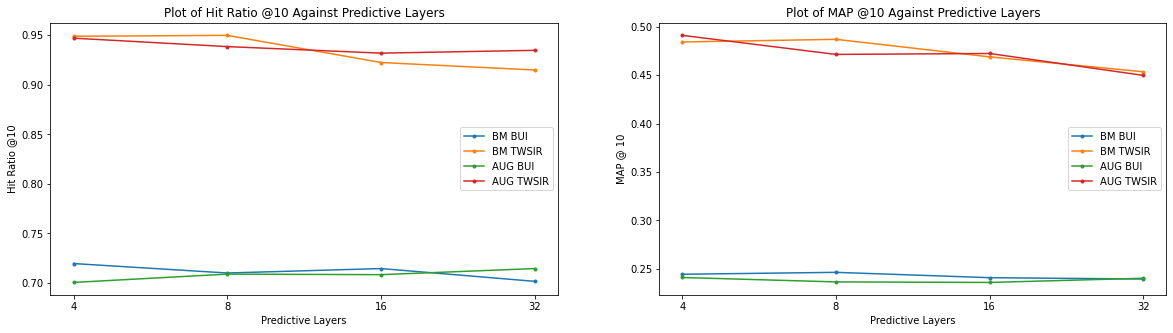

In [49]:
fig = plt.figure(figsize=(20,5))

# Plot HR@10
plt.subplot(1,2,1)
plt.plot([str(x) for x in PREDICTIVE_LAYERS], bm_bui_hrs, marker='.', label='BM BUI')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], bm_twsir_hrs, marker='.', label='BM TWSIR')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], aug_int_hrs, marker='.', label='AUG BUI')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], aug_twsir_hrs, marker='.', label='AUG TWSIR')
plt.xlabel('Predictive Layers')
plt.ylabel('Hit Ratio @10')
plt.title('Plot of Hit Ratio @10 Against Predictive Layers')
plt.legend()

plt.subplot(1,2,2)
plt.plot([str(x) for x in PREDICTIVE_LAYERS], bm_bui_mapks, marker='.', label='BM BUI')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], bm_twsir_mapks, marker='.', label='BM TWSIR')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], aug_int_mapks, marker='.', label='AUG BUI')
plt.plot([str(x) for x in PREDICTIVE_LAYERS], aug_twsir_mapks, marker='.', label='AUG TWSIR')
plt.xlabel('Predictive Layers')
plt.ylabel('MAP @ 10')
plt.title('Plot of MAP @10 Against Predictive Layers')
plt.legend()
plt.show()

### Generate Dummy Recommendation List

In [28]:
# Use best model which is benchmark TWSIR
EPOCHS = 10
LAYER = 8
REGS = [0,0,0]
LATENT_DIM = 8
USER_NUM, REST_NUM = twsir_np_grt_20.shape
LR = 1e-3
BATCH_SIZE = 1024
tf.random.set_seed(903347941)
MLP_DENSE = [LAYER*4,LAYER*2,LAYER]
nmf = neumf(USER_NUM, REST_NUM, LATENT_DIM, layers=MLP_DENSE, regs=REGS)
nmf.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy')
nmf.fit([X_train_twsir[:, :1], X_train_twsir[:, 1:]], Y_train_twsir, batch_size=BATCH_SIZE, epochs=EPOCHS)
predictions = nmf.predict([X_test_twsir[:, :1], X_test_twsir[:, 1:]])
true_pred = np.hstack((X_test_twsir, Y_test_twsir.reshape(-1,1), predictions))

Epoch 1/10
6737/6737 [==============================] - 11s 2ms/step - loss: 0.0547
Epoch 2/10
6737/6737 [==============================] - 10s 1ms/step - loss: 0.0445
Epoch 3/10
6737/6737 [==============================] - 10s 1ms/step - loss: 0.0423
Epoch 4/10
6737/6737 [==============================] - 10s 1ms/step - loss: 0.0410
Epoch 5/10
6737/6737 [==============================] - 11s 2ms/step - loss: 0.0404
Epoch 6/10
6737/6737 [==============================] - 11s 2ms/step - loss: 0.0400
Epoch 7/10
6737/6737 [==============================] - 10s 1ms/step - loss: 0.0396
Epoch 8/10
6737/6737 [==============================] - 10s 1ms/step - loss: 0.0394
Epoch 9/10
6737/6737 [==============================] - 11s 2ms/step - loss: 0.0391
Epoch 10/10
6737/6737 [==============================] - 10s 2ms/step - loss: 0.0389


In [46]:
# Restaurants
senti_rest = pd.read_csv('../data/restaurant_sentiment.csv')
users = pd.read_csv('../data/users.csv')
rest_detailed = pd.read_csv('../data/restaurants_detailed.csv')
zero = pd.DataFrame(true_pred[true_pred[:,0]==0], 
                    columns=['account_uuid', 'restaurant_uuid', 'True Ratings', 'Predicted Ratings'])
main = zero.merge(senti_rest, on='restaurant_uuid', how='inner')
main = main.merge(users, on='account_uuid', how='inner')
main = main.merge(rest_detailed, on='restaurant_code', how='inner')
main = main.sort_values('Predicted Ratings', ascending=False)

In [48]:
main[['account_id', 'restaurant_id','lat', 'long','intrinsic_rating']].reset_index(drop=True).to_csv('recs.csv', index=False)